In [1]:
# pylint: disable=unused-import
import sys
from datetime import date
print(f"revision date: {date.today()} with Python {sys.version}")
from qiskit import __version__
print(f"qiskit: {__version__}") 

revision date: 2025-01-26 with Python 3.12.8 (main, Dec  4 2024, 08:54:12) [GCC 11.4.0]
qiskit: 1.3.2


# Quantum Counting

To understand this algorithm, it is important that you first understand both Grover’s algorithm and the quantum phase estimation algorithm. Whereas Grover’s algorithm attempts to find a solution to the Oracle, the quantum counting algorithm tells us how many of these solutions there are. This algorithm is interesting as it combines both quantum search and quantum phase estimation.

## 1. Overview <a id='overview'></a>

### 1.1 Intuition <a id='intuition'></a>

In quantum counting, we simply use the quantum phase estimation algorithm to find an eigenvalue of a Grover search iteration. You will remember that an iteration of Grover’s algorithm, $G$, rotates the state vector by $\theta$ in the $|\omega\rangle$, $|s’\rangle$ basis:
![image1](images/quantum_counting1.svg)


The percentage number of solutions in our search space affects the difference between $|s\rangle$ and $|s’\rangle$. For example, if there are not many solutions, $|s\rangle$ will be very close to $|s’\rangle$ and $\theta$ will be very small. It turns out that the eigenvalues of the Grover iterator are $e^{\pm i\theta}$, and we can extract this using quantum phase estimation (QPE) to estimate the number of solutions ($M$).

### 1.2 A Closer Look <a id='closer_look'></a>

In the $|\omega\rangle$, $|s’\rangle$ basis we can write the Grover iterator as the matrix:

$$
G =
\begin{pmatrix}
\cos{\theta} && -\sin{\theta}\\
\sin{\theta} && \cos{\theta}
\end{pmatrix}
$$

The matrix $G$ has eigenvectors:

$$
\begin{pmatrix}
-i\\
1
\end{pmatrix}
,
\begin{pmatrix}
i\\
1
\end{pmatrix}
$$

With the aforementioned eigenvalues $e^{\pm i\theta}$. Fortunately, we do not need to prepare our register in either of these states, the state $|s\rangle$ is in the space spanned by $|\omega\rangle$, $|s’\rangle$, and thus is a superposition of the two vectors.
$$
|s\rangle = \alpha |\omega\rangle + \beta|s'\rangle
$$

As a result, the output of the QPE algorithm will be a superposition of the two phases, and when we measure the register we will obtain one of these two values! We can then use some simple maths to get our estimate of $M$.

![image2](images/quantum_counting2.svg)


## 2. The Code <a id='code'></a>

### 2.1 Initialising our Code <a id='init_code'></a>

First, let’s import everything we’re going to need:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# import basic plot tools
from qiskit.visualization import plot_histogram

In this guide will choose to ‘count’ on the first 4 qubits on our circuit (we call the number of counting qubits $t$, so $t = 4$), and to 'search' through the last 4 qubits ($n = 4$). With this in mind, we can start creating the building blocks of our circuit.

### 2.2 The Controlled-Grover Iteration <a id='cont_grover'></a>

We have already covered Grover iterations in the Grover’s algorithm section. Here we'll use the circuit library to quickly create a circuit that does one iteration of Grover's algorithm. The oracle we'll use has 5 solutions ($M = 5$) of 16 states ($N = 2^n = 16$).

In [3]:
def grover_operator(n_iterations):
    """Grover iteration circuit for oracle with 5/16 solutions
        Args:
            n_iterations (int): number of times to repeat the circuit
        Returns:
            Gate that implements n_iterations of the Grover operator
    """
    from qiskit.circuit.library import Diagonal, GroverOperator
    oracle = Diagonal([1,1,-1,1,1,1,1,-1,1,1,-1,-1,1,1,-1,1])
    grover_it = GroverOperator(oracle).repeat(n_iterations).to_gate()
    grover_it.label = f"Grover$^{n_iterations}$"
    return grover_it

Notice the python function takes no input and returns a `Gate` object with 4 qubits. Later in this page, we'll use the `.control()` method to create a controlled gate from a `Gate`.

### 2.3 The Inverse QFT <a id='inv_qft'></a>
We now need to create an inverse QFT. We'll import this from the circuit library, and create the gate with t = 4 qubits as this is the number of counting qubits we chose for our example:

Again, note we have chosen to return another `QuantumCircuit` object, this is so we can easily invert the gate. We create the gate with t = 4 qubits as this is the number of counting qubits we have chosen in this guide:

In [4]:
from qiskit.circuit.library import QFT
qft_dagger = QFT(4, inverse=True).to_gate()
qft_dagger.label = "QFT†"

### 2.4 Putting it Together <a id='putting_together'></a>

We now have everything we need to complete our circuit! Let’s put it together.

First we need to put all qubits in the $|+\rangle$ state:

In [5]:
# Create QuantumCircuit
t = 4   # no. of counting qubits
n = 4   # no. of searching qubits
qc = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

# Initialize all qubits to |+>
for qubit in range(t+n):
    qc.h(qubit)

# Begin controlled Grover iterations
n_iterations = 1
for qubit in range(t):
    cgrit = grover_operator(n_iterations).control()
    qc.append(cgrit, [qubit] + list(range(t, n+t)))
    n_iterations *= 2
    
# Do inverse QFT on counting qubits
qc.append(qft_dagger, range(t))

# Measure counting qubits
qc.measure(range(t), range(t))

# Display the circuit
qc.draw(fold=-1)

┌───┐                                                            ┌───────┐┌─┐         
q_0: ┤ H ├───────■────────────────────────────────────────────────────┤0      ├┤M├─────────
     ├───┤       │                                                    │       │└╥┘┌─┐      
q_1: ┤ H ├───────┼──────────────■─────────────────────────────────────┤1      ├─╫─┤M├──────
     ├───┤       │              │                                     │  QFT† │ ║ └╥┘┌─┐   
q_2: ┤ H ├───────┼──────────────┼──────────────■──────────────────────┤2      ├─╫──╫─┤M├───
     ├───┤       │              │              │                      │       │ ║  ║ └╥┘┌─┐
q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■───────┤3      ├─╫──╫──╫─┤M├
     ├───┤┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐└───────┘ ║  ║  ║ └╥┘
q_4: ┤ H ├┤0            ├┤0            ├┤0            ├┤0            ├──────────╫──╫──╫──╫─
     ├───┤│             ││             ││             ││             │          ║  ║  ║  ║ 
q_5: ┤ H ├┤1            ├┤1            ├┤1            ├┤1            ├──────────╫──╫──╫──╫─
     ├───┤│  Grover$^1$ ││  Grover$^2$ ││  Grover$^4$ ││  Grover$^8$ │          ║  ║  ║  ║ 
q_6: ┤ H ├┤2            ├┤2            ├┤2            ├┤2            ├──────────╫──╫──╫──╫─
     ├───┤│             ││             ││             ││             │          ║  ║  ║  ║ 
q_7: ┤ H ├┤3            ├┤3            ├┤3            ├┤3            ├──────────╫──╫──╫──╫─
     └───┘└─────────────┘└─────────────┘└─────────────┘└─────────────┘          ║  ║  ║  ║ 
c: 4/═══════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                0  1  2  3

Great! Now let’s see some results.

## 3. Simulating <a id='simulating'></a>

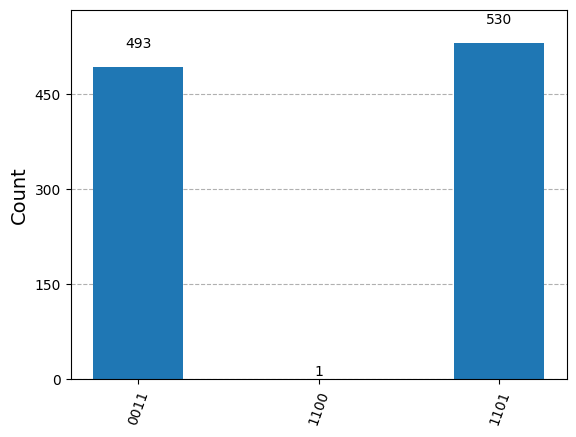

In [6]:
# Execute and see results
# sim = Aer.get_backend('aer_simulator')
sim = AerSimulator()
transpiled_qc = transpile(qc, sim)
job = sim.run(transpiled_qc)
hist = job.result().get_counts()
plot_histogram(hist)

We can see two values stand out, having a much higher probability of measurement than the rest. These two values correspond to $e^{i\theta}$ and $e^{-i\theta}$, but we can’t see the number of solutions yet. We need to little more processing to get this information, so first let us get our output into something we can work with (an `int`).

We will get the string of the most probable result from our output data (although either will do):

In [7]:
measured_str = max(hist, key=hist.get)

Let us now store this as an integer:

In [8]:
measured_int = int(measured_str, 2)
print("Register Output = %i" % measured_int)

Register Output = 13


## 4. Finding the Number of Solutions (M) <a id='finding_m'></a>

We will create a function, `calculate_M()` that takes as input the decimal integer output of our register, the number of counting qubits ($t$) and the number of searching qubits ($n$).

First we want to get $\theta$ from `measured_int`. You will remember that QPE gives us a measured $\text{value} = 2^n \phi$ from the eigenvalue $e^{2\pi i\phi}$, so to get $\theta$ we need to do:

$$
\theta = \text{value}\times\frac{2\pi}{2^t}
$$

Or, in code:

In [9]:
theta = (measured_int/(2**t))*math.pi*2
print("Theta = %.5f" % theta)

Theta = 5.10509


You may remember that we can get the angle $\theta/2$ can from the inner product of $|s\rangle$ and $|s’\rangle$:

![image3](images/quantum_counting3.svg)

$$
\langle s'|s\rangle = \cos{\tfrac{\theta}{2}}
$$

And that $|s\rangle$ (a uniform superposition of computational basis states) can be written in terms of $|\omega\rangle$ and $|s'\rangle$ as:

$$
|s\rangle = \sqrt{\tfrac{M}{N}}|\omega\rangle + \sqrt{\tfrac{N-M}{N}}|s'\rangle
$$

The inner product of $|s\rangle$ and $|s'\rangle$ is:

$$
\langle s'|s\rangle = \sqrt{\frac{N-M}{N}} = \cos{\tfrac{\theta}{2}}
$$

From this, we can use some trigonometry and algebra to show:

$$
N\sin^2{\frac{\theta}{2}} = M
$$

And in code:

In [10]:
N = 2**n
M = N * (math.sin(theta/2)**2)
print(f"No. of Solutions = {M:.1f}")

No. of Solutions = 4.9


And we can see we have (approximately) the correct answer! We can approximately calculate the error in this answer using:

In [11]:
m = t - 1 # Upper bound: Will be less than this 
err = (math.sqrt(2*M*N) + N/(2**(m+1)))*(2**(-m))
print("Error < %.2f" % err)

Error < 1.70


Explaining the error calculation is outside the scope of this article, but an explanation can be found in [1].

Finally, here is the finished function `calculate_M()`:

In [13]:
def calculate_M(measured_int, t, n):
    """For Processing Output of Quantum Counting"""
    # Calculate Theta
    theta = (measured_int/(2**t))*math.pi*2
    print("Theta = %.5f" % theta)
    # Calculate No. of Solutions
    N = 2**n
    M = N * (math.sin(theta/2)**2)
    print(f"No. of Solutions = {M:.1f}")
    # Calculate Upper Error Bound
    m = t - 1 #Will be less than this (out of scope) 
    err = (math.sqrt(2*M*N) + N/(2**(m+1)))*(2**(-m))
    print("Error < %.2f" % err)

# pylint: disable=unused-import
import sys
from datetime import date
print(f"revision date: {date.today()} with Python {sys.version}")

revision date: 2025-01-26 with Python 3.12.8 (main, Dec  4 2024, 08:54:12) [GCC 11.4.0]


## 5. Exercises <a id='exercises'></a>

1.	Can you create an oracle with a different number of solutions? How does the accuracy of the quantum counting algorithm change?
2.	Can you adapt the circuit to use more or less counting qubits to get a different precision in your result?
